In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import hyperopt
import euclidemu2 as ee2
import keras
import train_utils as utils
from train_utils import params, lims, ref

2023-05-16 16:36:37.140663: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-16 16:36:37.169547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
redshifts = [0, 0.5, 1.0, 2.0, 3.0]

## $\Lambda$CDM - 400 training points

### Data preprocessing

In [3]:
# Calculate ref cosmology from CAMB, all redshifts
ref_pk_lin = np.zeros((len(redshifts), len(utils.ks_400)))
ref_pk_nl = np.zeros((len(redshifts), len(utils.ks_400)))
ref_pk_lin_smear = np.zeros((len(redshifts), len(utils.ks_400)))
for i, redshift in enumerate(redshifts):
    ks, ref_pk_lin[i], ref_pk_nl[i] = np.loadtxt(f"./power_spectra/lcdm/400/pk_ref_z_{redshift:.3f}.txt", unpack=True)
    ref_pk_lin_smear[i] = utils._smeared_bao_pk(k_lin=ks, pk_lin=ref_pk_lin[i], k_emu=ks, pk_lin_emu=ref_pk_lin[i])

In [4]:
train_samples_400 = np.loadtxt(f"./power_spectra/lcdm/400/lcdm_train_400.txt")
val_samples = np.loadtxt(f"./power_spectra/lcdm/val_50/lcdm_val_50.txt")
print(train_samples_400[0])
print(val_samples[0])

[2.41886529e-01 5.82436493e-02 9.72340153e-01 1.97524136e-09
 6.16233447e-01]
[2.576e-01 5.980e-02 9.768e-01 2.412e-09 7.120e-01]


In [9]:
# Read training data, 400 spectra
pks_lin_train400 = np.zeros((len(train_samples_400), len(redshifts), len(utils.ks_400)))
pks_lin_smear_train400 = np.zeros((len(train_samples_400), len(redshifts), len(utils.ks_400)))
pks_nl_train400 = np.zeros((len(train_samples_400), len(redshifts), len(utils.ks_400)))

for i in range(len(train_samples_400)):
    for j, redshift in enumerate(redshifts):
        ks, pks_lin_train400[i,j], pks_nl_train400[i,j] = np.loadtxt(f"./power_spectra/lcdm/400/pk_{i}_z_{redshift:.3f}.txt", unpack=True)
        pks_lin_smear_train400[i,j] = utils._smeared_bao_pk(k_lin=ks, pk_lin=pks_lin_train400[i,j], k_emu=ks, pk_lin_emu=pks_lin_train400[i,j])

In [10]:
# Read validation data, 50 spectra
pks_lin_val = np.zeros((len(val_samples), len(redshifts), len(utils.ks_400)))
pks_lin_smear_val = np.zeros((len(val_samples), len(redshifts), len(utils.ks_400)))
pks_nl_val = np.zeros((len(val_samples), len(redshifts), len(utils.ks_400)))

for i in range(len(val_samples)):
    for j, redshift in enumerate(redshifts):
        ks, pks_lin_val[i,j], pks_nl_val[i,j] = np.loadtxt(f"./power_spectra/lcdm/val_50/pk_{i}_z_{redshift:.3f}.txt", unpack=True)
        pks_lin_smear_val[i,j] = utils._smeared_bao_pk(k_lin=ks, pk_lin=pks_lin_val[i,j], k_emu=ks, pk_lin_emu=pks_lin_val[i,j])

In [11]:
# Defining emulated quantities
train_logboosts = np.log(pks_nl_train400/pks_lin_train400)
train_qs = np.log(pks_nl_train400/pks_lin_smear_train400)

val_logboosts = np.log(pks_nl_val/pks_lin_val)
val_qs = np.log(pks_nl_val/pks_lin_smear_val)

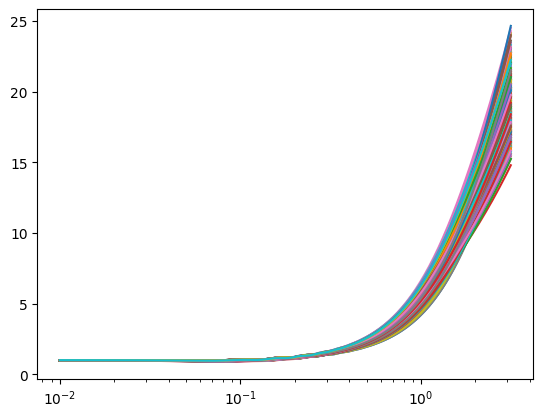

In [13]:
for i in range(400):
    plt.semilogx(ks, np.exp(train_logboosts[i,0]))

In [14]:
# Normalized parameters - input for NN
train_sample_norm = np.zeros((len(train_samples_400),5))
val_sample_norm = np.zeros((len(val_samples),5))
for i, (train_point, val_point) in enumerate(zip(train_samples_400, val_samples)):
    train_sample_norm[i] = utils.normalize_params(train_point)
    val_sample_norm[i] = utils.normalize_params(val_point)

In [15]:
# Normalized Boosts with Min-Max
train_logboosts_norm = np.zeros((len(train_samples_400), len(redshifts), len(ks)))
train_qs_norm = np.zeros((len(train_samples_400), len(redshifts), len(ks)))
for i in range(len(redshifts)):
    train_logboosts_norm[:,i,:] = utils.normalize_array(train_logboosts[:,i,:]) # I normalize within each redshift
    train_qs_norm[:,i,:] = utils.normalize_array(train_qs[:,i,:]) # I normalize within each redshift

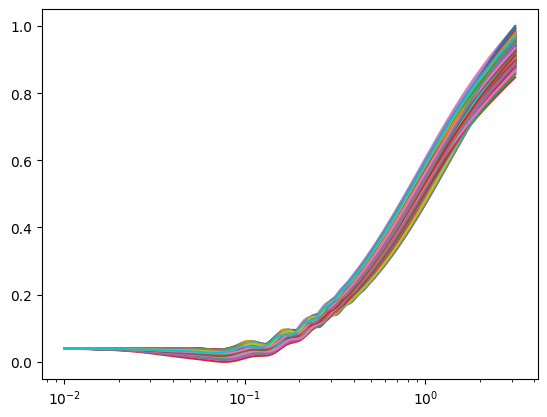

In [17]:
for i in range(400):
    plt.semilogx(ks, train_logboosts_norm[i,0])

In [18]:
# Getting and saving min and max for rescaling
mins_logboosts = np.zeros(len(redshifts))
maxs_logboosts = np.zeros(len(redshifts))
mins_qs = np.zeros(len(redshifts))
maxs_qs = np.zeros(len(redshifts))

for i in range(len(redshifts)):
    mins_logboosts[i] = np.amin(train_logboosts[:,i,:])
    maxs_logboosts[i] = np.amax(train_logboosts[:,i,:])
    mins_qs[i] = np.amin(train_qs[:,i,:])
    maxs_qs[i] = np.amax(train_qs[:,i,:])

In [19]:
# "Normalizing" validation data
# Note: we need to use the training maxs and mins!
val_logboosts_norm = np.zeros((len(val_samples), len(redshifts), len(ks)))
val_qs_norm = np.zeros((len(val_samples), len(redshifts), len(ks)))
for i in range(len(redshifts)):
    val_logboosts_norm[:,i,:] = (val_logboosts[:,i,:] - mins_logboosts[i])/(maxs_logboosts[i] - mins_logboosts[i])
    val_qs_norm[:,i,:] = (val_qs[:,i,:] - mins_qs[i])/(maxs_qs[i] - mins_qs[i])

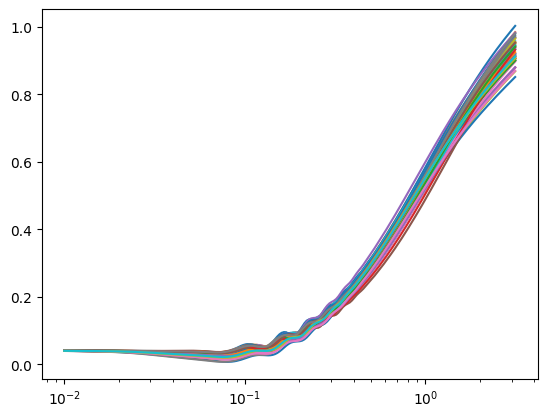

In [21]:
for i in range(50):
    plt.semilogx(ks, val_logboosts_norm[i,0])

In [22]:
# PCA reduction
num_pcs = 6
pcas_logboosts, train_logboosts_pcs = utils.pca_reduction(num_pcs, train_logboosts_norm, redshifts)
pcas_qs, train_qs_pcs = utils.pca_reduction(num_pcs, train_qs_norm, redshifts)

In [23]:
# PCA reduction of validation data
val_logboosts_pcs = np.zeros((len(val_samples), len(redshifts), num_pcs))
val_qs_pcs = np.zeros((len(val_samples), len(redshifts), num_pcs))
for i in range(len(redshifts)):
    val_logboosts_pcs[:,i,:] = pcas_logboosts[i].transform(val_logboosts_norm[:,i,:])
    val_qs_pcs[:,i,:] = pcas_qs[i].transform(val_qs_norm[:,i,:])

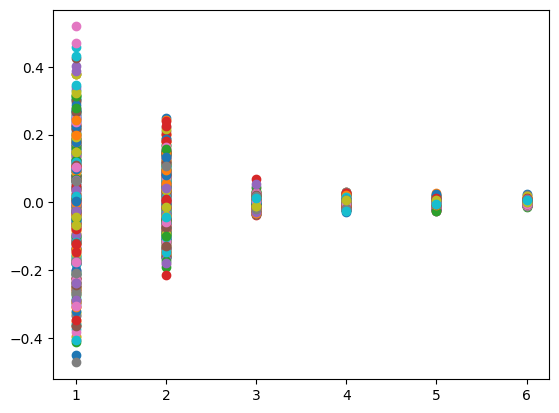

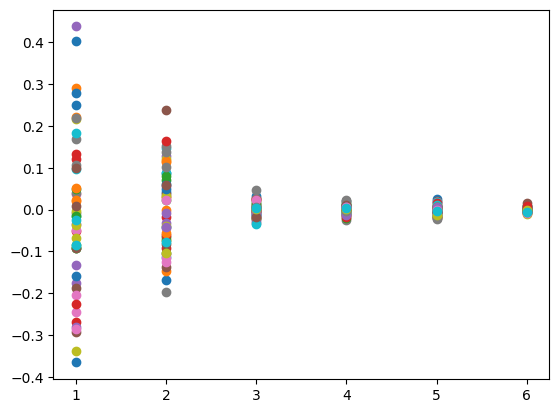

In [24]:
for i in range(400):
    plt.scatter([1,2,3,4,5,6], train_logboosts_pcs[i,0])
plt.show()
for i in range(50):
    plt.scatter([1,2,3,4,5,6], val_logboosts_pcs[i,0])

In [55]:
# Normalizing PCs
norm_pcs_logboosts_train = np.zeros((len(train_samples_400), len(redshifts), num_pcs))
norm_pcs_qs_train = np.zeros((len(train_samples_400), len(redshifts), num_pcs))
for i in range(len(redshifts)):
    for j in range(num_pcs):
        norm_pcs_logboosts_train[:,i,j] = utils.normalize_array(reduced_norm_logboosts_train[:,i,j]) # I normalize within each redshift
        norm_pcs_qs_train[:,i,j] = utils.normalize_array(reduced_norm_qs_train[:,i,j]) # I normalize within each redshift

# Saving mins and maxs for rescaling
mins_logboosts_pcs = np.zeros((len(redshifts), num_pcs))
maxs_logboosts_pcs = np.zeros((len(redshifts), num_pcs))
mins_qs_pcs = np.zeros((len(redshifts), num_pcs))
maxs_qs_pcs = np.zeros((len(redshifts), num_pcs))
for i in range(len(redshifts)):
    for j in range(num_pcs):
        mins_logboosts_pcs[i,j] = np.amin(reduced_norm_logboosts_train[:,i,j])
        maxs_logboosts_pcs[i,j] = np.amax(reduced_norm_logboosts_train[:,i,j])
        mins_qs_pcs[i,j] = np.amin(reduced_norm_qs_train[:,i,j])
        maxs_qs_pcs[i,j] = np.amax(reduced_norm_qs_train[:,i,j])

# Normalizing validation PCs
# Note: once again, we need to normalize with training maxs and mins
norm_pcs_logboosts_val = np.zeros((len(val_samples), len(redshifts), num_pcs))
norm_pcs_qs_val = np.zeros((len(val_samples), len(redshifts), num_pcs))
for i in range(len(redshifts)):
    for j in range(num_pcs):
        norm_pcs_logboosts_val[:,i,j] = (reduced_norm_logboosts_val[:,i,j] - mins_logboosts_pcs[i,j])/(maxs_logboosts_pcs[i,j] - mins_logboosts_pcs[i,j])
        norm_pcs_qs_val[:,i,j] = (reduced_norm_qs_val[:,i,j] - mins_qs_pcs[i,j])/(maxs_qs_pcs[i,j] - mins_qs_pcs[i,j])

### Training

In [26]:
# Generate resnet model
resnet = utils.generate_resnet(num_pcs, 1, train_sample_norm, num_of_neurons=1024, alpha=1e-4, l1_ratio=0.1, dropout=0)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         6144        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1024)         1049600     ['dense[0][0]']                  
                                                                                                  
 add (Add)                      (None, 1024)         0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']            

In [27]:
# Generate MLP model
mlp = utils.generate_model_regularized(num_pcs, 2, train_sample_norm, num_of_neurons=1024, alpha=1e-4, l1_ratio=0.1, dropout=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hid_layer_1 (Dense)         (None, 1024)              6144      
                                                                 
 hid_layer_2 (Dense)         (None, 1024)              1049600   
                                                                 
 out_layer (Dense)           (None, 6)                 6150      
                                                                 
Total params: 1,061,894
Trainable params: 1,061,894
Non-trainable params: 0
_________________________________________________________________


In [34]:
def nn_model_train(model, epochs, input_data, truths, validation_features, validation_truths):
    '''
    Creates and trains a neural network model that emulates the pc_components from the input_data
    Returns
    '''
    
    model.compile(
        optimizer = keras.optimizers.Adam(),
        loss = keras.losses.MeanAbsoluteError()
    )
    
    def scheduler(epoch, learning_rate):
        # Halves the learning rate at some points during training
        if epoch != 0 and epoch % 300 == 0:
            return learning_rate/2
        else:
            return learning_rate
    learning_scheduler = keras.callbacks.LearningRateScheduler(scheduler)
    
    history = model.fit(
        input_data,
        truths,
        batch_size = 30,
        epochs = epochs,
        validation_data = (validation_features, validation_truths),
        callbacks=[learning_scheduler],
    )
    last_loss = history.history['loss'][-1]
    return last_loss

In [ ]:
last_loss = nn_model_train(resnet, 500, train_sample_norm, train_logboosts_pcs[:,0], val_sample_norm, val_qs_pcs[:,0])

Epoch 1/500
14/14 [==============================] - 1s 22ms/step - loss: 0.3584 - val_loss: 0.2746 - lr: 0.0010
Epoch 2/500
14/14 [==============================] - 0s 14ms/step - loss: 0.2251 - val_loss: 0.1646 - lr: 0.0010
Epoch 3/500
14/14 [==============================] - 0s 17ms/step - loss: 0.1344 - val_loss: 0.0974 - lr: 0.0010
Epoch 4/500
14/14 [==============================] - 0s 11ms/step - loss: 0.0833 - val_loss: 0.0649 - lr: 0.0010
Epoch 5/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0626 - val_loss: 0.0546 - lr: 0.0010
Epoch 6/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0546 - val_loss: 0.0492 - lr: 0.0010
Epoch 7/500
14/14 [==============================] - 0s 11ms/step - loss: 0.0508 - val_loss: 0.0467 - lr: 0.0010
Epoch 8/500
14/14 [==============================] - 0s 7ms/step - loss: 0.0489 - val_loss: 0.0455 - lr: 0.0010
Epoch 9/500
14/14 [==============================] - 0s 17ms/step - loss: 0.0480 - val_loss: 0.044

14/14 [==============================] - 0s 6ms/step - loss: 0.0464 - val_loss: 0.0436 - lr: 0.0010
Epoch 74/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0464 - val_loss: 0.0436 - lr: 0.0010
Epoch 75/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0464 - val_loss: 0.0436 - lr: 0.0010
Epoch 76/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0464 - val_loss: 0.0435 - lr: 0.0010
Epoch 77/500
14/14 [==============================] - 0s 15ms/step - loss: 0.0464 - val_loss: 0.0436 - lr: 0.0010
Epoch 78/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0464 - val_loss: 0.0436 - lr: 0.0010
Epoch 79/500
14/14 [==============================] - 0s 7ms/step - loss: 0.0464 - val_loss: 0.0436 - lr: 0.0010
Epoch 80/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0464 - val_loss: 0.0435 - lr: 0.0010
Epoch 81/500
14/14 [==============================] - 0s 8ms/step - loss: 0.0464 - val_loss: 0.0435 - lr

Epoch 145/500
14/14 [==============================] - 0s 6ms/step - loss: 0.0464 - val_loss: 0.0436 - lr: 0.0010
Epoch 146/500
14/14 [==============================] - 0s 16ms/step - loss: 0.0464 - val_loss: 0.0436 - lr: 0.0010
Epoch 147/500
14/14 [==============================] - 0s 22ms/step - loss: 0.0464 - val_loss: 0.0436 - lr: 0.0010
Epoch 148/500
 1/14 [=>............................] - ETA: 0s - loss: 0.0451

### Evaluating model

In [42]:
test_samples = np.loadtxt('./power_spectra/lcdm/300/lhs.txt')
print(test_samples[0])

[3.28556559e-01 4.47950480e-02 9.39366935e-01 2.13014792e-09
 6.68111933e-01]


In [43]:
pks_lin_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
pks_nl_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
for i in range(len(test_samples)):
    ks, pks_lin_test[i], pks_nl_test[i] = np.loadtxt(f"./power_spectra/lcdm/300/pk_{i}_z_0.000.txt", unpack=True)

In [44]:
test_boosts = pks_nl_test/pks_lin_test

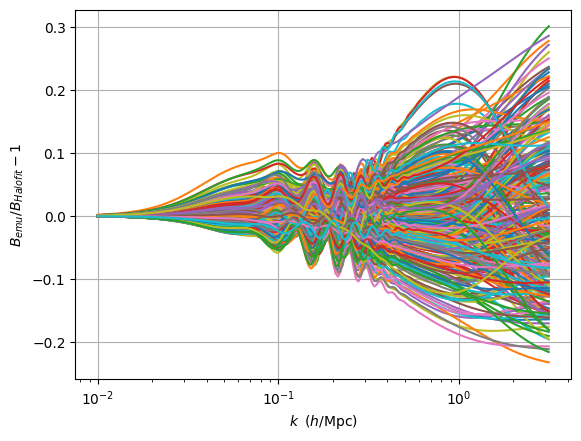

In [46]:
# ResNet
z = 0
nn_model = emulator_model
errors = np.zeros((len(test_samples), len(ks)))
for i, (test_sample, test_boost) in enumerate(zip(test_samples, test_boosts)):
    norm_params = utils.normalize_params(test_sample)
    nn_test_output = nn_model(np.array([norm_params])) # Normalized PCs
    output_pcs = nn_test_output# * (maxs_logboosts_pcs[z] - mins_logboosts_pcs[z]) + mins_logboosts_pcs[z] # PCs
    output_norm_log_boosts = pcas_logboosts[z].inverse_transform(output_pcs) # Norm logboost
    output_log_boosts = output_norm_log_boosts * (maxs_logboosts[z] - mins_logboosts[z]) + mins_logboosts[z] # Logboost
    output_boost = np.exp(output_log_boosts)[0] # Boost
    errors[i] = output_boost/test_boost[z] - 1
    plt.semilogx(ks, errors[i])    
plt.xlabel('$k \;\; (h/\mathrm{Mpc})$')
plt.ylabel('$B_{emu} / B_{Halofit} - 1$')
#plt.ylim([-0.015, 0.015])
plt.grid()
#plt.fill_between(ks, -0.01, 0.01, color='gray', alpha=0.4)
#plt.savefig(f'./halofit_training_set_decision_tests/HALOFIT_ERRORS_LCDM_Z{redshifts[z]:.1f}_800PTS_ARCH1_TEST50.pdf')
#np.savetxt(f"./halofit_training_set_decision_tests/HALOFIT_EMU_ERRORS_LCDM_Z{redshifts[z]:.1f}_800PTS_ARCH1_TEST50.txt", errors)